In [39]:
import os
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import galsim
import webbpsf
from utils import PSNR
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift

%matplotlib inline

In [40]:
webbpsf.setup_logging('ERROR')

WebbPSF log messages of level ERROR and above will be shown.
WebbPSF log outputs will be directed to the screen.


In [41]:
# nc = webbpsf.NIRCam()
# print(nc.pixelscale)
# psf = nc.calc_psf(nlambda=5, fov_arcsec=2)
# webbpsf.display_psf(psf)
# print(psf.info())

In [42]:
# plt.figure(figsize=(10,10))
# for i in range(4):
#     plt.subplot(2,2,i+1)
#     plt.imshow(psf[i].data)

In [47]:
COSMOS_dir = './data/COSMOS_23.5_training_sample/'
idx = 1437
scale = 5
gal_flux = 1e5
nc = webbpsf.NIRCam()
pixel_scale = nc.pixelscale
real_galaxy_catalog = galsim.RealGalaxyCatalog(dir=COSMOS_dir, sample=str(23.5))
gal_ori = galsim.RealGalaxy(real_galaxy_catalog, index = idx, flux = gal_flux)
psf_ori = real_galaxy_catalog.getPSF(i=idx)
gal = galsim.Convolve([psf_ori, gal_ori])
gal_image = galsim.ImageF(80, 80)
gal.drawImage(gal_image, scale=pixel_scale, method='auto')
gal_image = gal_image.array

# pad/crop webbpsf
h, w = gal_image.shape
psf_list = nc.calc_psf(nlambda=5, fov_arcsec=2)
psf = psf_list[1].data
psf_pad = np.zeros([h,w])
starti = (gal_image.shape[0]- psf.shape[0])//2
endi = starti + psf.shape[0]
startj = (gal_image.shape[1]//2) - (psf.shape[1]//2)
endj = startj + psf.shape[1]
psf_pad[starti:endi, startj:endj] = psf

psf_pad = torch.from_numpy(psf_pad)
gal_image = torch.from_numpy(gal_image)
obs = ifftshift(ifft2(fft2(psf_pad) * fft2(gal_image))).real

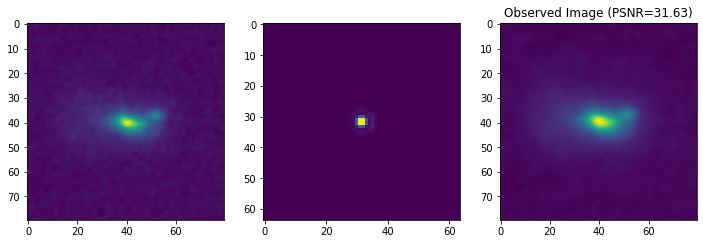

In [48]:
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(gal_image)

plt.subplot(1,3,2)
plt.imshow(psf)

plt.subplot(1,3,3)
plt.imshow(obs)
plt.title('Observed Image (PSNR={:.2f})'.format(PSNR(gal_image, obs)))
plt.show()

<JWST: NIRCam>
<JWST: NIRCam>
<JWST: NIRSpec>
<JWST: NIRISS>
<JWST: MIRI>
<JWST: FGS>


AttributeError: 'HDUList' object has no attribute 'values'

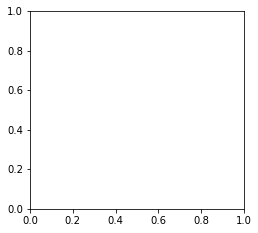

In [63]:
# Iterate over all instruments, calculating one example PSF for each
insts = ['NIRCam','NIRCam','NIRSpec','NIRISS', 'MIRI', 'FGS']
filts = ['F210M', 'F444W', 'F110W', 'F380M', 'F1000W', 'FGS']

psfs = {}
for i, (instname, filt) in enumerate(zip(insts, filts)):
    inst = webbpsf.instrument(instname)
    inst.filter = filt
    psf = inst.calc_psf(fov_arcsec=5.0)
    psfs[instname+filt] = psf
    print(inst)



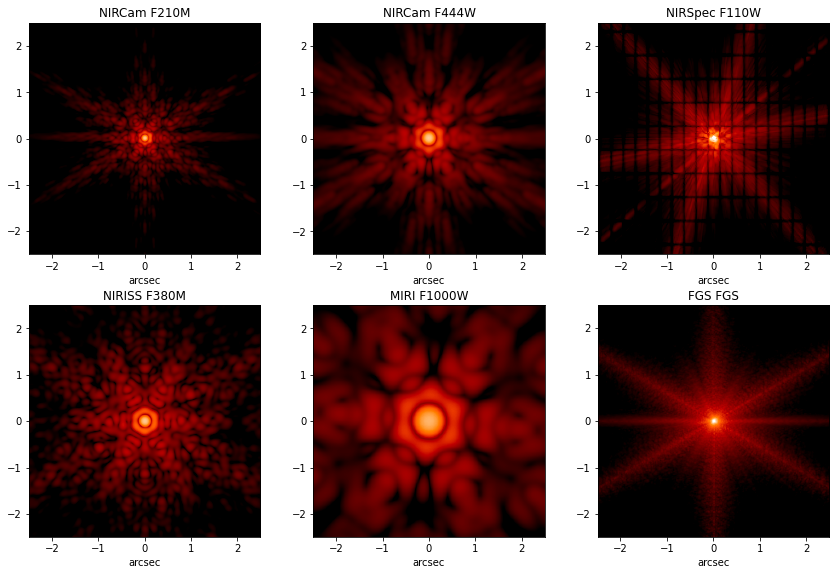

In [68]:
# Now make a nice plot of them
plt.figure(figsize=(12,8))
plt.subplots_adjust(wspace=0.05, bottom=0.05, top=0.9)
for i, (instname, filt) in enumerate(zip(insts, filts)):
    ax = plt.subplot(2,3,1+i)
    webbpsf.display_psf(psfs[instname+filt], colorbar=False, title=instname+" "+filt, vmax=0.03, imagecrop=5)
plt.tight_layout()
plt.savefig('fig_instrument_comparison.png', dpi=150)